# Regularizations

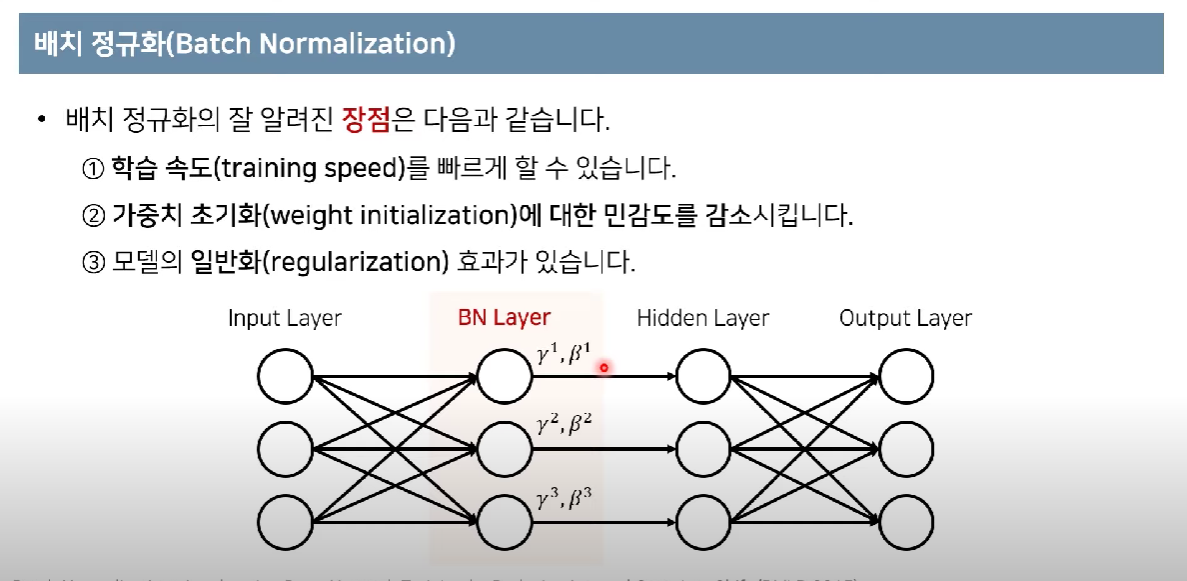

In [9]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\9.png")

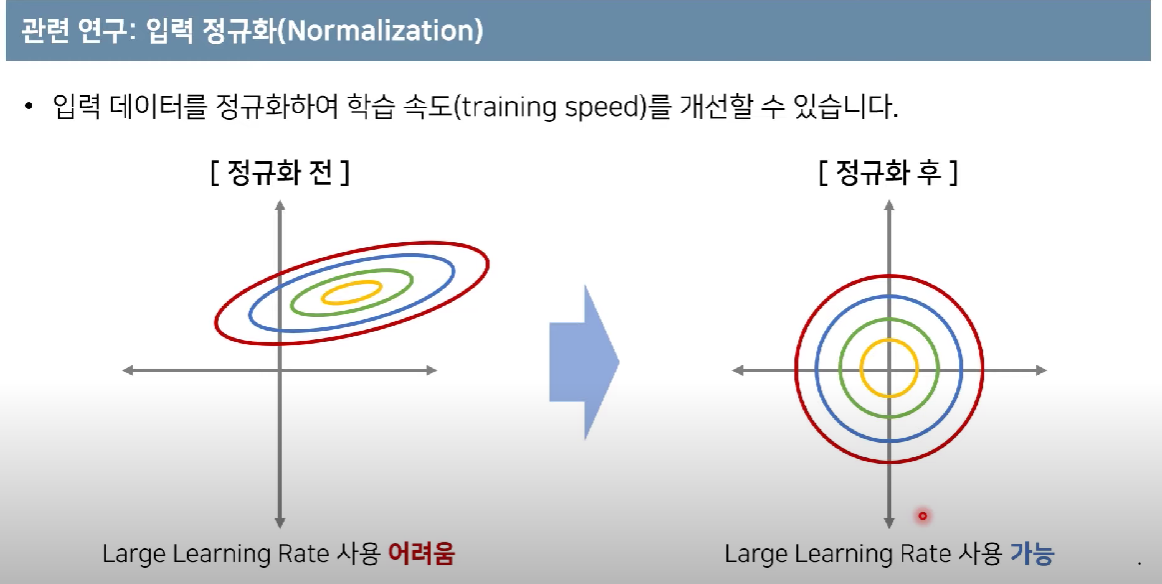

In [10]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\10.png")

 이미지는 각 픽셀당 0부터 255를 가지는게 일반적. 정규화하면 0부터 1까지의 값을 가짐. 정규화 전은 Input data의 분포가 일관적이지 않아 큰 learning rate 사용하기 어렵다. 하지만 정규화후는 큰 Learning rate 사용할수있어 training speed가 빠름

이번 챕터에서도 MNIST 데이터셋을 활용하여 정규화reguarlization 실습을 진행해보도록 하겠습니다. 앞서 딥러닝을 활용한 분류 문제 실습에서도 MNIST 데이터셋에 대해서 진행하였었는데, 과연 성능이 오르는지 확인해보도록 하겠습니다. 필요한 라이브러리들을 불러옵니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
from torchvision import datasets, transforms
from IPython.display import Image

60,000장의 학습 샘플과 10,000장의 테스트 샘플을 각각 불러올 수 있습니다.

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [6]:
x.size()

torch.Size([60000, 784])

In [7]:
#MNIST 데이터셋의 데이터는 0부터 255까지의 정수인 회색조 값으로 저장되어 있습니다. 이를 0부터 1 사이의 실수로 바꿉니다
x = train.data.float() / 255.
y = train.targets #self.targets : 기존에 tuple 형식이던 데이터를 각각 list 형태로 받아옴

x = x.view(x.size(0), -1) #뷰(View)는 넘파이에서의 리쉐이프(Reshape)와 같은 역할을 합니다. 
#위에서 정규화한 x를 가지고 x.size(0)으로 reshape
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1 #0~9까지 9개에서 +1하면 총10개

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


중요한 점은 이전 실습에서와 같이 2차원 이미지 행렬을 1차원 벡터로 변환했다는 것입니다. 따라서 학습 데이터의 입력과 출력 텐서 크기는 다음과 같습니다.

In [5]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices) #셔플링
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0)) #indices차원만큼 쪼개기
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)] #test data를 정규분포만들고 test 개수만큼 차원바꿔주기
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## Build Regularized Model & Optimizer

학습 코드 구현
앞서의 실습에서는 대부분 nn.Sequential에 원하는 계층과 활성함수를 집어넣어 쉽고 간편하게 모델을 구현할 수 있었습니다. 이번에도 비슷하게 진행할 수 있지만, 한 단계 발전된 방향으로 나아가고자 합니다. 사실 생각해보면 앞서의 실습들에서 활용된 모델들도 선형 계층linear layer과 비선형 활성 함수non-linear activation function의 반복이었습니다. 즉, 하나의 층이 선형 계층과 비선형 활성 함수의 조합으로 이루어지게 되고, 이것을 전체 모듈에 대한 부분 모듈 또는 서브 모듈로 볼 수 있습니다. 그럼 서브 모듈이 입출력 크기만 바뀌어서 반복되고 있던 것으로 볼 수 있습니다. 이번에는 여기에 정규화 계층이 더해져 “선형 계층 + 비선형 활성 함수 + 정규화 계층”이 하나의 서브 모듈이 될 것이고, 마찬가지로 입출력 크기만 바뀌어서 반복 사용되는 것입니다. 그럼 이것에 착안하여 서브 모듈을 nn.Module을 상속받아 하나의 클래스로 정의하고, nn.Sequential에 “선형 계층 + 비선형 활성 함수 + 정규화 계층”을 각각 인자로 넣어주는 대신에, 정의한 클래스 객체를 넣어주면 될 것입니다.

다음 코드는 서브 모듈 클래스를 정의하는 코드입니다. 이 모듈은 생성시에 배치 정규화batch normalization와 드랍아웃dropout 중에서 선택받고, 입출력 크기를 입력받습니다. 그래서 self.block에 선형 계층, 리키 렐루, 정규화 계층을 nn.Sequential에 넣어 가지고 있습니다. 배치 정규화를 사용한 경우에는 앞서 사용된 선형 계층의 출력 크기를 넣어주어야 하고, 드랍아웃의 경우에는 확률 값을 넣어주어야 합니다. 그리고 forward 함수에서 피드포워드를 구현해줍니다

In [11]:
class Block(nn.Module): #Linear(), LeakyReLU(), batch_norm()을 대신 쓰는 함수. 이 함수안에 3개의 함수를 쓰는거임.즉 줄여서 쓸라고 함수정의함
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True, #batch_norm은 batch들을 정규화하고 scale + scale 하는거
                 dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        
        #Regularization 
        
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p) #batch_norm 또는 dropout을 return함
        # nn.BatchNorm1d(size)은 정규화해주는 함수
        # batch_norm 의 경우에는 몇개 차원의 batchnorm을 실행할지 넣어주고 
        # dropout의 경우에는 nn.Dropout하고 몇퍼센트 확률로 node를 drop할건지 적어주면 된다.  
        #Linear Layer 출력사이즈가 위 BatchNorm 사이즈 입력사이즈
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size), #활성화함수 뒤에 넣준다
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)
        
        return y

In [7]:
class MyModel(nn.Module): 
#nn.Sequential 썼는데 그거 안쓰고 MyModel이라는걸 정의해서 nn.Module를 상속받아서 __init__함수와 __forward__함수 overwrite한다
    
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True, #use_batch_norm = False이면 dropout을 설정
                 dropout_p=.4):
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p), 
            #Block 함수에 input size가 들어가면 self.block를 하나 만들어지고 그걸 forward함수를 통해서 통과시킴. 그걸 이제 반복해서 생성 
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p), #여기서 batch_norm 이 결과값인 상황
            nn.Linear(100, output_size), # 그래서 추가적으로 각 클래스별로 log확률값을 뱉어줘야하니깐 100을 10으로 빼주는 Linear layer,
            nn.LogSoftmax(dim=-1), #log softmax를 써준다
            # 그래서 우리는 두개의 nn.Module를 상속받는 나만의 class를 정의하고 Mymodel 클래스는 Block 클래스를 재활용해서 여러개를 생성해서 
            # nn.Sequential 에 넣어서 간단하게 구현해준다.
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)        
        y = self.layers(x)
        # |y| = (batch_size, output_size) # 784차원이 들어와서 10차원으로 나가게한다.
        
        return y

In [8]:
model = MyModel(input_size,
                output_size,
                use_batch_norm=True)
# sequential 에 하드코딩한거랑 똑같음.그걸 그냥 이쁘게 쓴거임
model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [9]:
crit = nn.NLLLoss()

In [10]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [12]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

## Train

In [13]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [14]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

Train mode는 실제 학습할 때 사용하는 모드이며 dropout을 이용하여 노드를 껐다 켰다 하게 된다. Evaluation mode는 검증할 때 선언 후, dropout을 사용하지 않고 전체 뉴런을 상용한다.

Batch Normalization에서도 이 모드를 사용하는데, train과 실제 inference, 테스트를 할 때 차이점이 존재하기 때문에 사용한다.

#### 왜 Batch Normalization에서도 사용해야 하는가?
batch size 값을 정한 뒤, 뉴럴 네트워크에 넣어서 학습하게 된다. 시그마와 뮤 값을 평균과 분산을 계산한다. 다음으로 normalize를 진행하여 X hat을 계산한다. 그 다음, 학습했던 감마를 X hat에 곱하고 베타를 더하는 방식으로 transform을 한다.

 최종적으로 Batch Normalization 하는 과정에서 X가 변경되면 뮤와 variance가 전혀 다른 값이 나올 수 있다. 즉, batch 값이 바뀌면다른 결과가 나올 수 있다. 따라서 이 과정에서도 trian과 evaluation 모드를 따로 둔다.

 

In [15]:
train_history, valid_history = [], []

for i in range(n_epochs): 
    model.train() ## <- 이거 까먹으면 안돼!! 중요해!!!
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    model.eval() ##이거 까먹으면 안돼! 중요해!!
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.0227e-02  valid_loss=8.2649e-02  lowest_loss=7.1724e-02
Epoch 20: train loss=1.1667e-02  valid_loss=9.5184e-02  lowest_loss=7.1724e-02
Epoch 30: train loss=1.1116e-02  valid_loss=8.3793e-02  lowest_loss=7.1724e-02
Epoch 40: train loss=5.0038e-03  valid_loss=8.4098e-02  lowest_loss=7.1724e-02
Epoch 50: train loss=8.0331e-03  valid_loss=9.5511e-02  lowest_loss=7.1724e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 7: 7.1724e-02


<All keys matched successfully>

## Loss History

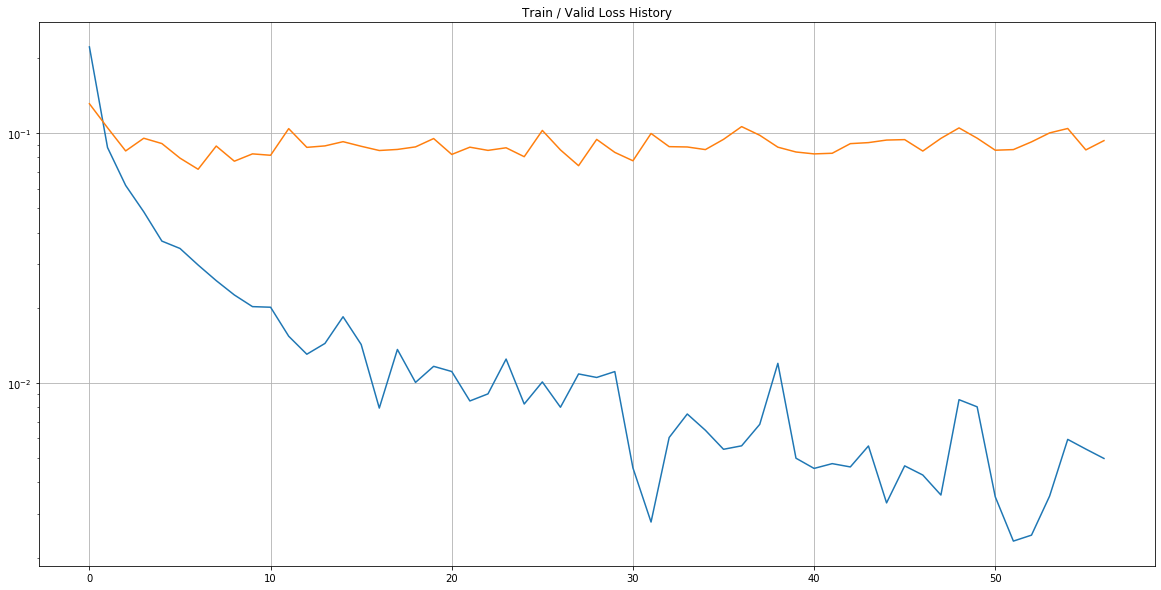

In [16]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [17]:
test_loss = 0
y_hat = []

model.eval() # 이 코드는 무조건 써야해! 어떤 regularization 쓰든간에 무조건 써야하는거임
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 6.9124e-02


In [18]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9793


In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [20]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,967,0,1,0,1,2,5,1,2,1
true_1,0,1130,2,1,0,0,1,0,1,0
true_2,1,2,1003,1,5,0,5,8,6,1
true_3,0,0,5,993,0,3,0,5,2,2
true_4,2,0,1,0,953,1,3,1,0,21
true_5,1,0,1,11,1,867,5,1,4,1
true_6,0,3,0,0,9,6,937,1,2,0
true_7,2,4,6,0,1,1,0,1010,1,3
true_8,1,0,2,4,2,3,0,2,956,4
true_9,2,2,0,5,6,1,1,11,4,977
